In [2]:
import simpy
import random
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import os
import json

In [2]:
# # Helper function to generate random patient arrival times
# def static_arrival_time(i):
#     if (i > 0):
#         return (datetime.datetime.combine(datetime.date.today(), ARRIVAL_TIME[i]) - datetime.datetime.combine(datetime.date.today(), ARRIVAL_TIME[i-1])).total_seconds()
#     else:
#         return 0.0

# def arrival_time(num_patients, start_time, end_time, peak_times):
#      # peak arrival times in hours
#     st_sec = datetime.datetime.timestamp(datetime.datetime.combine(datetime.date.today(), start_time))
#     et_sec = datetime.datetime.timestamp(datetime.datetime.combine(datetime.date.today(), end_time))
#     thresh1 = datetime.datetime.timestamp(datetime.datetime.combine(datetime.date.today(), datetime.time(2, 0)))
#     thresh2 = datetime.datetime.timestamp(datetime.datetime.combine(datetime.date.today(), datetime.time(0, 1)))
#     arrival_interval = (et_sec - st_sec) / num_patients
#     arrival_times = []
#     for i in range(num_patients):
#         arrival_time = st_sec + (i * arrival_interval)
#         # print(arrival_time)
#         # Add weightage to the times that are near the peak times and the time that is near start time
#         for peak_time in peak_times:
#             pt_sec = datetime.datetime.timestamp(datetime.datetime.combine(datetime.date.today(), peak_time))
#             if abs(arrival_time - pt_sec) <= 120 or abs(arrival_time - st_sec) <= 120:
#                 arrival_time += (np.random.rand() + 0.5) * arrival_interval
#         arrival_times.append(arrival_time)
#     # Add randomness to the arrival times
#     arrival_times = np.array(arrival_times) + (np.random.rand(num_patients) - 0.5) * arrival_interval
#     return arrival_times

# def interval_gen(arrival_time_list):
#     interval = [0, 0]
#     for i in range(1, len(arrival_time_list)-1):
#         interval.append(abs((datetime.datetime.fromtimestamp(arrival_time_list[i+1]) - datetime.datetime.fromtimestamp(arrival_time_list[i])).total_seconds()))
#     for k in range(len(interval)-1):
#         if random.randint(0,2) == 1:
#             interval[k+1] = interval[k] + interval[k+1]
#             interval[k] = 0
#     return interval

def interval_gen(num_patients):
    x_data = np.arange(len(BASELINE_ARRIVALS))
    y_data = np.array(BASELINE_ARRIVALS).reshape(len(BASELINE_ARRIVALS),)

    # Interpolate to 100 values
    interp = interp1d(x_data, y_data, kind='cubic')
    x_interp = np.linspace(0, len(BASELINE_ARRIVALS)-1, num_patients)
    y_interp = interp(x_interp)
    y_out = np.interp(y_interp, (0, max(y_data)), (0, max(y_data)))
    return np.asarray(y_out, dtype = 'int')

# Helper function to generate random consultation decisions
def consultation_decision():
    return random.random() < 0.5

# Helper function to generate random scan/xray decisions
def ip_decision():
    return random.choices([0, 1], weights=[0.66666, 0.33333])[0]

def oldOP_scan_decision():
    # return random.randint(0,4)
    return random.choices([0, 1, 2, 3, 4], weights=[0.08333, 0.16666, 0.08333, 0.33333, 0.33333])[0]

def NewOP_decision(): 
    return random.choices([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], weights=[0.15, 0.1, 0.05, 0.05, 0.1, 0.3, 0.05, 0.05, 0.05, 0.05, 0.05])[0]

def OldOP_decision(): 
    return random.choices([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], weights=[0.03846, 0.03846, 0.07692, 0.07692, 0.03846, 0.19230, 0.07692, 0.15384, 0.23076, 0.07692])[0]

In [3]:
def plot_wait_times(wait_times, path, fname):
    plt.plot(wait_times)
    plt.ylabel('Wait Time (minutes)')
    plt.xlabel('Patient ID')
    plt.title('Avg: {:.2f}, Min: {:.2f}, Max: {:.2f}' .format(np.average(wait_times), np.min(wait_times), np.max(wait_times)))
    plt.savefig(path + fname)
    plt.show()

def plot_visits(services, visits, path, fname):
    plt.bar(services, visits)
    plt.ylabel('Visits')
    plt.xlabel('Services')
    plt.title('Avg: {:.2f}, Min: {:.2f}, Max: {:.2f}' .format(np.average(visits), np.min(visits), np.max(visits)))
    plt.savefig(path + fname)
    plt.show()

def plot_times(services, time, path, fname):
    plt.bar(services, time)
    plt.ylabel('Time')
    plt.xlabel('Services')
    plt.title('Avg: {:.2f}, Min: {:.2f}, Max: {:.2f}' .format(np.average(time), np.min(time), np.max(time)))
    plt.savefig(path + fname)
    plt.show()

In [4]:
# Define patient type
def p_type():
    return random.choices(['NewOP', 'OldOP', 'OldOPScan', 'IP'], weights=[0.328, 0.358, 0.179, 0.134])[0]

# Create the patient arrival process
def patient_arrival(env, doctors, registration, xray, scan, dressing, injection, pharmacy, billing):
    # arrival_time_list = arrival_time(NUM_PATIENTS, START_TIME, MAX_TIME, PEAK_TIMES)
    # intervals = interval_gen(arrival_time_list)
    intervals = interval_gen(NUM_PATIENTS)
    for i in range(NUM_PATIENTS):
        # a_time = arrival_time_list[i]
        # art.append(a_time)
        delays.append(intervals[i])
        yield env.timeout(intervals[i])
        current_time = datetime.datetime.fromtimestamp(env.now).time()
        # print(MAX_TIME)
        # if current_time > MAX_TIME:
        #     break
        env.process(patient_flow(env, doctors, registration, xray, scan, dressing, injection, pharmacy, billing, "Patient %d" % i))

In [5]:
# Create the registration process
def registration_process(env, registration, patient):
    global num_registration, reg_wait_times, reg_service_times
    num_registration += 1
    print("%s arriving at the registration desk at %s." % (patient, datetime.datetime.fromtimestamp(env.now).strftime('%X %p')), file=f)
    arrival_time = env.now
    processing_time = REGISTRATION_TIME + np.random.uniform(0,5)
    with registration.request() as req:
        yield req
        start_time = env.now
        print("%s starting registration process at %s." % (patient, datetime.datetime.fromtimestamp(start_time).strftime('%X %p')), file=f)
        yield env.timeout(processing_time)
        finish_time = env.now
        print("%s finishing registration process at %s." % (patient, datetime.datetime.fromtimestamp(finish_time).strftime('%X %p')), file=f)
    total_wait_time = (start_time - arrival_time)/60
    # print("%s waited %s minutes at the registration desk" % (patient, datetime.datetime.fromtimestamp(total_wait_time).strftime('%X %p')))
    print("%s waited %s minutes at the registration desk" % (patient, total_wait_time), file=f)
    reg_wait_times.append(total_wait_time)
    reg_service_times.append(processing_time)
    flow[patient].update({'Registration': {'arrival': datetime.datetime.fromtimestamp(arrival_time).strftime('%X %p'), 'start': datetime.datetime.fromtimestamp(start_time).strftime('%X %p'), 'finish': datetime.datetime.fromtimestamp(finish_time).strftime('%X %p'), 'wait': str(datetime.timedelta(minutes=total_wait_time))}})
    return total_wait_time

# Create the consultation process
def consultation(env, doctors, patient):
    global num_consultation, cons_wait_times, cons_service_times
    num_consultation += 1
    print("%s arriving at the consultation room at %s." % (patient, datetime.datetime.fromtimestamp(env.now).strftime('%X %p')), file=f)
    arrival_time = env.now
    processing_time = CONSULTATION_TIME + np.random.uniform(0,5)
    with doctors.request() as req:
        yield req
        start_time = env.now
        print("%s starting consultation with a doctor at %s." % (patient, datetime.datetime.fromtimestamp(start_time).strftime('%X %p')), file=f)
        yield env.timeout(processing_time)
        finish_time = env.now
        print("%s finishing consultation with a doctor at %s." % (patient, datetime.datetime.fromtimestamp(finish_time).strftime('%X %p')), file=f)
    total_wait_time = (start_time - arrival_time)/60
    print("%s waited %s minutes at the consultation room" % (patient, total_wait_time), file=f)
    cons_wait_times.append(total_wait_time)
    cons_service_times.append(processing_time)
    flow[patient].update({'Consultation': {'arrival': datetime.datetime.fromtimestamp(arrival_time).strftime('%X %p'), 'start': datetime.datetime.fromtimestamp(start_time).strftime('%X %p'), 'finish': datetime.datetime.fromtimestamp(finish_time).strftime('%X %p'), 'wait': str(datetime.timedelta(minutes=total_wait_time))}})
    return total_wait_time

# Create the pharmacy process
def pharmacy_process(env, pharmacy, patient):
    global num_pharmacy, phar_wait_times, phar_service_times
    num_pharmacy += 1
    print("%s arriving at the pharmacy at %s." % (patient, datetime.datetime.fromtimestamp(env.now).strftime('%X %p')), file=f)
    arrival_time = env.now
    processing_time = PHARMACY_TIME + np.random.uniform(0,5)
    with pharmacy.request() as req:
        yield req
        start_time = env.now
        print("%s starting pharmacy process at %s." % (patient, datetime.datetime.fromtimestamp(start_time).strftime('%X %p')), file=f)
        yield env.timeout(processing_time)
        finish_time = env.now
        print("%s finishing pharmacy process at %s." % (patient, datetime.datetime.fromtimestamp(finish_time).strftime('%X %p')), file=f)
    total_wait_time = (start_time - arrival_time)/60
    print("%s waited %s minutes at the pharmacy" % (patient, total_wait_time), file=f)
    phar_wait_times.append(total_wait_time)
    phar_service_times.append(processing_time)
    flow[patient].update({'Pharmacy': {'arrival': datetime.datetime.fromtimestamp(arrival_time).strftime('%X %p'), 'start': datetime.datetime.fromtimestamp(start_time).strftime('%X %p'), 'finish': datetime.datetime.fromtimestamp(finish_time).strftime('%X %p'), 'wait': str(datetime.timedelta(minutes=total_wait_time))}})
    return total_wait_time

# Create the dressing process
def dressing_process(env, dressing, patient):
    global num_dressing, dress_wait_times, dress_service_times
    num_dressing += 1
    print("%s arriving at the dressing desk at %s." % (patient, datetime.datetime.fromtimestamp(env.now).strftime('%X %p')), file=f)
    arrival_time = env.now
    processing_time = DRESSING_TIME + np.random.uniform(0,5)
    with dressing.request() as req:
        yield req
        start_time = env.now
        print("%s starting dressing process at %s." % (patient, datetime.datetime.fromtimestamp(start_time).strftime('%X %p')), file=f)
        yield env.timeout(processing_time)
        finish_time = env.now
        print("%s finishing dressing process at %s." % (patient, datetime.datetime.fromtimestamp(finish_time).strftime('%X %p')), file=f)
    total_wait_time = (start_time - arrival_time)/60
    print("%s waited %s minutes at the dressing desk" % (patient, total_wait_time), file=f)
    dress_wait_times.append(total_wait_time)
    dress_service_times.append(processing_time)
    flow[patient].update({'Dressing': {'arrival': datetime.datetime.fromtimestamp(arrival_time).strftime('%X %p'), 'start': datetime.datetime.fromtimestamp(start_time).strftime('%X %p'), 'finish': datetime.datetime.fromtimestamp(finish_time).strftime('%X %p'), 'wait': str(datetime.timedelta(minutes=total_wait_time))}})
    return total_wait_time

# Create the xray process
def xray_process(env, xray, patient):
    global num_xray, xray_wait_times, xray_service_times
    num_xray += 1
    print("%s arriving at the xray room at %s." % (patient, datetime.datetime.fromtimestamp(env.now).strftime('%X %p')), file=f)
    arrival_time = env.now
    processing_time = XRAY_TIME + np.random.uniform(0,5)
    with xray.request() as req:
        yield req
        start_time = env.now
        print("%s starting xray process at %s." % (patient, datetime.datetime.fromtimestamp(start_time).strftime('%X %p')), file=f)
        yield env.timeout(processing_time)
        finish_time = env.now
        print("%s finishing xray process at %s." % (patient, datetime.datetime.fromtimestamp(finish_time).strftime('%X %p')), file=f)
    total_wait_time = (start_time - arrival_time)/60
    print("%s waited %s minutes at the xray room" % (patient, total_wait_time), file=f)
    xray_wait_times.append(total_wait_time)
    xray_service_times.append(processing_time)
    flow[patient].update({'Xray': {'arrival': datetime.datetime.fromtimestamp(arrival_time).strftime('%X %p'), 'start': datetime.datetime.fromtimestamp(start_time).strftime('%X %p'), 'finish': datetime.datetime.fromtimestamp(finish_time).strftime('%X %p'), 'wait': str(datetime.timedelta(minutes=total_wait_time))}})
    return total_wait_time

# Create the scan process
def scan_process(env, scan, patient):
    global num_scan, scan_wait_times, scan_service_times
    num_scan += 1
    print("%s arriving at the scan at %s." % (patient, datetime.datetime.fromtimestamp(env.now).strftime('%X %p')), file=f)
    arrival_time = env.now
    processing_time = SCAN_TIME + np.random.uniform(0,5)
    with scan.request() as req:
        yield req
        start_time = env.now
        print("%s starting scan process at %s." % (patient, datetime.datetime.fromtimestamp(start_time).strftime('%X %p')), file=f)
        yield env.timeout(processing_time)
        finish_time = env.now
        print("%s finishing scan process at %s." % (patient, datetime.datetime.fromtimestamp(finish_time).strftime('%X %p')), file=f)
    total_wait_time = (start_time - arrival_time)/60
    print("%s waited %s minutes at the scan" % (patient, total_wait_time), file=f)
    scan_wait_times.append(total_wait_time)
    scan_service_times.append(processing_time)
    flow[patient].update({'Scan': {'arrival': datetime.datetime.fromtimestamp(arrival_time).strftime('%X %p'), 'start': datetime.datetime.fromtimestamp(start_time).strftime('%X %p'), 'finish': datetime.datetime.fromtimestamp(finish_time).strftime('%X %p'), 'wait': str(datetime.timedelta(minutes=total_wait_time))}})
    return total_wait_time

# Create the billing process
def billing_process(env, billing, patient):
    global num_billing, bill_wait_times, bill_service_times
    num_billing += 1
    print("%s arriving at the billing room at %s." % (patient, datetime.datetime.fromtimestamp(env.now).strftime('%X %p')), file=f)
    arrival_time = env.now
    processing_time = BILLING_TIME + np.random.uniform(0,5)
    with billing.request() as req:
        yield req
        start_time = env.now
        print("%s starting billing process at %s." % (patient, datetime.datetime.fromtimestamp(start_time).strftime('%X %p')), file=f)
        yield env.timeout(processing_time)
        finish_time = env.now
        print("%s finishing billing process at %s." % (patient, datetime.datetime.fromtimestamp(finish_time).strftime('%X %p')), file=f)
    total_wait_time = (start_time - arrival_time)/60
    print("%s waited %s minutes at the billing room" % (patient, total_wait_time), file=f)
    bill_wait_times.append(total_wait_time)
    bill_service_times.append(processing_time)
    flow[patient].update({'Billing': {'arrival': datetime.datetime.fromtimestamp(arrival_time).strftime('%X %p'), 'start': datetime.datetime.fromtimestamp(start_time).strftime('%X %p'), 'finish': datetime.datetime.fromtimestamp(finish_time).strftime('%X %p'), 'wait': str(datetime.timedelta(minutes=total_wait_time))}})
    return total_wait_time

# Create the injection process
def injection_process(env, injection, patient):
    global num_injection, inj_wait_times, inj_service_times
    num_injection += 1
    print("%s arriving at the injection at %s." % (patient, datetime.datetime.fromtimestamp(env.now).strftime('%X %p')), file=f)
    arrival_time = env.now
    processing_time = INJECTION_TIME + np.random.uniform(0,5)
    with injection.request() as req:
        yield req
        start_time = env.now
        print("%s starting injection process at %s." % (patient, datetime.datetime.fromtimestamp(start_time).strftime('%X %p')), file=f)
        yield env.timeout(processing_time)
        finish_time = env.now
        print("%s finishing injection process at %s." % (patient, datetime.datetime.fromtimestamp(start_time).strftime('%X %p')), file=f)
    total_wait_time = (start_time - arrival_time)/60
    print("%s waited %s minutes at the injection" % (patient, total_wait_time), file=f)
    inj_wait_times.append(total_wait_time)
    inj_service_times.append(processing_time)
    flow[patient].update({'Injection': {'arrival': datetime.datetime.fromtimestamp(arrival_time).strftime('%X %p'), 'start': datetime.datetime.fromtimestamp(start_time).strftime('%X %p'), 'finish': datetime.datetime.fromtimestamp(finish_time).strftime('%X %p'), 'wait': str(datetime.timedelta(minutes=total_wait_time))}})
    return total_wait_time

In [6]:
# Define patient flow
def patient_flow(env, doctors, registration, xray, scan, dressing, injection, pharmacy, billing, patient):
    patient_type = p_type()
    total_wait_time = 0
    s_time = env.now
    flow[patient] = {}
    # patient_type = ARRIVAL_TIME[i][1]
    print("%s is a %s patient." % (patient, patient_type), file=f)
    d0 = NewOP_decision()
    d1 = OldOP_decision()
    d2 = oldOP_scan_decision()
    if patient_type == 'NewOP':
        if(d0 == 0):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(xray_process(env, xray, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(pharmacy_process(env, pharmacy, patient))
            total_wait_time += yield env.process(dressing_process(env, dressing, patient))
        elif(d0 == 1):
            # Incomplete flow
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            print("%s left the hospital at %s" % (patient, datetime.datetime.fromtimestamp(env.now).strftime('%X %p')), file=f)
        elif(d0 == 2):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(pharmacy_process(env, pharmacy, patient))
            total_wait_time += yield env.process(dressing_process(env, dressing, patient))
            total_wait_time += yield env.process(pharmacy_process(env, pharmacy, patient))
        elif(d0 == 3):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(pharmacy_process(env, pharmacy, patient))
            total_wait_time += yield env.process(dressing_process(env, dressing, patient))
        elif(d0 == 4):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(xray_process(env, xray, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
        elif(d0 == 5):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(pharmacy_process(env, pharmacy, patient))
        elif(d0 == 6):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(dressing_process(env, dressing, patient))
        elif(d0 == 7):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(injection_process(env, injection, patient))
        elif(d0 == 8):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(scan_process(env, scan, patient))
        elif(d0 == 9):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(xray_process(env, xray, patient))
        elif(d0 == 10):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(scan_process(env, scan, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(pharmacy_process(env, pharmacy, patient))
            

    if patient_type == 'OldOP':
        if(d1 == 0):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(xray_process(env, xray, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(pharmacy_process(env, pharmacy, patient))
            total_wait_time += yield env.process(dressing_process(env, dressing, patient))
        elif(d1 == 1):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(xray_process(env, xray, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(pharmacy_process(env, pharmacy, patient))
        elif(d1 == 2):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(xray_process(env, xray, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(pharmacy_process(env, pharmacy, patient))
        elif(d1 == 3):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(pharmacy_process(env, pharmacy, patient))
            total_wait_time += yield env.process(dressing_process(env, dressing, patient))
        elif(d1 == 4):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
        elif(d1 == 5):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(pharmacy_process(env, pharmacy, patient))
        elif(d1 == 6):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(dressing_process(env, dressing, patient))
        elif(d1 == 7):
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(injection_process(env, injection, patient))
        elif(d1 == 8):
            # Incomplete flow
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            print("%s left the hospital at %s" % (patient, datetime.datetime.fromtimestamp(env.now).strftime('%X %p')), file=f)
        elif(d1 == 9):
            # Incomplete flow
            total_wait_time += yield env.process(registration_process(env, registration, patient))
            print("%s left the hospital at %s" % (patient, datetime.datetime.fromtimestamp(env.now).strftime('%X %p')), file=f)
    
    elif patient_type == 'OldOPScan':
        total_wait_time += yield env.process(billing_process(env, billing, patient))
        if(d2 == 0):
            total_wait_time += yield env.process(xray_process(env, xray, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(pharmacy_process(env, pharmacy, patient))
            total_wait_time += yield env.process(dressing_process(env, dressing, patient))
        elif(d2 == 1):
            total_wait_time += yield env.process(xray_process(env, xray, patient))
            total_wait_time += yield env.process(consultation(env, doctors, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(pharmacy_process(env, pharmacy, patient))
        elif(d2 == 2):
            total_wait_time += yield env.process(xray_process(env, xray, patient))
            total_wait_time += yield env.process(billing_process(env, billing, patient))
            total_wait_time += yield env.process(pharmacy_process(env, pharmacy, patient))
        elif(d2 == 3):
            total_wait_time += yield env.process(xray_process(env, xray, patient))
        elif(d2 == 4):
            total_wait_time += yield env.process(scan_process(env, scan, patient))
    
    elif patient_type == 'IP':
        if(ip_decision == 0):
            total_wait_time += yield env.process(scan_process(env, scan, patient))
        else:
            total_wait_time += yield env.process(xray_process(env, xray, patient))
    e_time = env.now
    processing_times.append((e_time - s_time)/60)
    wait_times.append(total_wait_time)

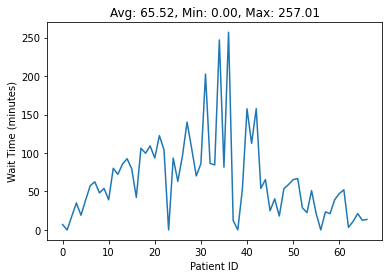

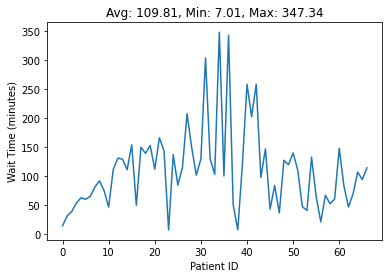

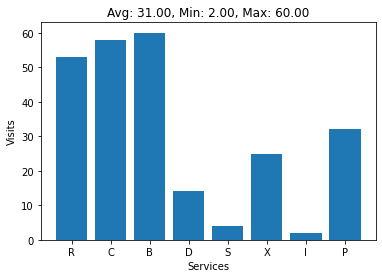

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

In [7]:
BASELINE_ARRIVALS = pd.read_csv('baseline_intervals.txt')
START_TIME = datetime.time(7, 30) # 7:30 AM
MAX_TIME = datetime.time(18, 45) # 6:45 PM
MAX_WAIT_TIME = 35*60

init = pd.read_csv('init.csv')

for i in range(len(init.index)):
    # Constants
    NUM_PATIENTS = init['NUM_PATIENTS'][i]

    NUM_REGISTRATION_COUNTERS = init['NUM_REGISTRATION_COUNTERS'][i]
    REGISTRATION_TIME = init['REGISTRATION_TIME'][i]*60 # seconds

    NUM_DOCTORS = init['NUM_DOCTORS'][i]
    CONSULTATION_TIME = init['CONSULTATION_TIME'][i]*60 # seconds

    NUM_PHARMACY_COUNTERS = init['NUM_PHARMACY_COUNTERS'][i]
    PHARMACY_TIME = init['PHARMACY_TIME'][i]*60 # seconds

    NUM_BILLING_COUNTERS = init['NUM_BILLING_COUNTERS'][i]
    BILLING_TIME = init['BILLING_TIME'][i]*60 # seconds

    NUM_XRAY_COUNTERS = init['NUM_XRAY_COUNTERS'][i]
    XRAY_TIME = init['XRAY_TIME'][i]*60 # seconds

    NUM_SCAN_COUNTERS = init['NUM_SCAN_COUNTERS'][i]
    SCAN_TIME = init['SCAN_TIME'][i]*60 # seconds

    NUM_INJECTION_COUNTERS = init['NUM_INJECTION_COUNTERS'][i]
    INJECTION_TIME = init['INJECTION_TIME'][i]*60 # seconds

    NUM_DRESSING_COUNTERS = init['NUM_DRESSING_COUNTERS'][i]
    DRESSING_TIME = init['DRESSING_TIME'][i]*60 # seconds

    # Create the simulation environment
    # env = simpy.Environment()
    env = simpy.Environment(initial_time = datetime.datetime.combine(datetime.date.today(), START_TIME).timestamp())

    # Create the Doctor resource
    doctors = simpy.PriorityResource(env, capacity=NUM_DOCTORS)

    # Create the registration resource
    registration = simpy.PriorityResource(env, capacity=NUM_REGISTRATION_COUNTERS)

    # Create the pharmacy resource
    pharmacy = simpy.PriorityResource(env, capacity=NUM_PHARMACY_COUNTERS)

    # Create the billing resource
    billing = simpy.PriorityResource(env, capacity=NUM_BILLING_COUNTERS)

    # Create the scan resource
    scan = simpy.PriorityResource(env, capacity=NUM_SCAN_COUNTERS)

    # Create the xray resource
    xray = simpy.PriorityResource(env, capacity=NUM_XRAY_COUNTERS)

    # Create the injection resource
    injection = simpy.PriorityResource(env, capacity=NUM_INJECTION_COUNTERS)

    # Create the dressing resource
    dressing = simpy.PriorityResource(env, capacity=NUM_DRESSING_COUNTERS)

    # Run the simulation
    wait_times = []
    processing_times = []
    art = []
    delays = []
    flow = {}

    # Define counters for each service
    num_registration = 0
    num_consultation = 0
    num_scan = 0
    num_pharmacy = 0
    num_xray = 0
    num_billing = 0
    num_dressing = 0
    num_injection = 0

    reg_wait_times = []
    cons_wait_times = []
    phar_wait_times = []
    dress_wait_times = []
    xray_wait_times = []
    scan_wait_times = []
    bill_wait_times = []
    inj_wait_times = []

    reg_service_times = []
    cons_service_times = []
    phar_service_times = []
    dress_service_times = []
    xray_service_times = []
    scan_service_times = []
    bill_service_times = []
    inj_service_times = []

    path = 'results/%s/'%i
    os.makedirs(path, exist_ok=True)

    f = open(path + "logs.txt", "w")
    env.process(patient_arrival(env, doctors, registration, xray, scan, dressing, injection, pharmacy, billing))
    env.run()
    f.close()

    # Plot wait times and proe=cessing times
    plot_wait_times(wait_times, path, 'wait_times.png')
    plot_wait_times(processing_times, path, 'processing_times.png')

    # Print the number of patients visited each service
    f2 = open(path + "frequency.txt", "w")
    print("Number of patients visited registration: %d" %num_registration, file=f2)
    print("Number of patients visited consultation: %d" %num_consultation, file=f2)
    print("Number of patients visited scan: %d" %num_scan, file=f2)
    print("Number of patients visited pharmacy: %d" %num_pharmacy, file=f2)
    print("Number of patients visited xray: %d" %num_xray, file=f2)
    print("Number of patients visited billing: %d" %num_billing, file=f2)
    print("Number of patients visited dressing: %d" %num_dressing, file=f2)
    print("Number of patients visited injection: %d" %num_injection, file=f2)
    f2.close()

    services = ['R', 'C', 'B', 'D', 'S', 'X', 'I', 'P']
    visits = [num_registration, num_consultation, num_billing, num_dressing, num_scan, num_xray, num_injection, num_pharmacy]
    plot_visits(services, visits, path, 'num_visits_per_service.png')
    np.savetxt(path + 'visits_per_service', visits)

    with open(path + 'flow_data.json', 'w') as fp:
        json.dump(flow, fp)

    df = pd.read_json(path + 'flow_data.json', orient='index')
    df.to_csv(path + 'flow_data.csv')
    # Save arrival tmes
    # arrival_time_stamps = []
    # for j in range(len(art)):
    #     arrival_time_stamps.append(datetime.datetime.fromtimestamp(art[j]).strftime('%X'))

    # np.savetxt(path + 'arrivals.txt', arrival_time_stamps, fmt='%s')

    def avg_times():
        wait_time_per_process = [reg_wait_times,
                                cons_wait_times,
                                phar_wait_times,
                                dress_wait_times,
                                xray_wait_times,
                                scan_wait_times,
                                bill_wait_times,
                                inj_wait_times,]

        service_time_per_process = [reg_service_times,
                                    cons_service_times,
                                    phar_service_times,
                                    dress_service_times,
                                    xray_service_times,
                                    scan_service_times,
                                    bill_service_times,
                                    inj_service_times,]

        for j in range(len(wait_time_per_process)):
            wait_time_per_process[j] = np.average(wait_time_per_process[j])
            service_time_per_process[j] = np.average(service_time_per_process[j])/60
        
        return wait_time_per_process, service_time_per_process


    # Plot Wait times and service times
    wait_time_per_process, service_time_per_process = avg_times()

    services = ['R', 'C', 'B', 'D', 'S', 'X', 'I', 'P']
    waits = wait_time_per_process
    service = service_time_per_process
    np.savetxt(path + 'wait_times_per_process.txt', waits)
    np.savetxt(path + 'service_times_per_process.txt', service)

    plot_times(services, waits, path, 'wait_times_per_service.png')
    plot_times(services, service, path, 'service_times_per_service.png')